In [1]:
## imports
import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import cartopy.mpl.ticker as cticker
import matplotlib.ticker as mticker

import eofs
from eofs.xarray import Eof
import cftime
import nc_time_axis
import cmocean as cmo
import mtspec
import csv 
# from pylab import *

import datetime
import time
import glob, os
import math
import matplotlib.colors as colors
from defs import difmodel
import scipy
from defs import lon180



In [2]:
folder = ''
modellist =  ['GISS2.1G', 'EC-Earth3-LR', 'CCSM4-UoT', 'CCSM4-Utr','CCSM4', 'CESM1.2', 'CESM2', 'IPSL-CM5A', 'IPSL-CM5A2','IPSL-CM6A','MIROC4m','COSMOS', 'HadCM3', 'NorESM1-F','HadGEM3']

In [3]:
#Open saved datasets that contain 100-year mean SSS and SST for all models
#SSS files have been saved in Fig05Fig08.ipynb
#SST files have been saved in Fig02.ipynb

sssE280 = xr.open_dataset('/Users/6497241/surfdrive/Documents/PlioMIP2-OHT/Data/Processed/sssE280.nc').sss
sssEoi400 = xr.open_dataset('/Users/6497241/surfdrive/Documents/PlioMIP2-OHT/Data/Processed/sssEoi400.nc').sss

sstE280 = xr.open_dataset('/Users/6497241/surfdrive/Documents/PlioMIP2-OHT/Data/Processed/sstE280.nc').sst
sstEoi400 = xr.open_dataset('/Users/6497241/surfdrive/Documents/PlioMIP2-OHT/Data/Processed/sstEoi400.nc').sst
sstE280

<xarray.DataArray 'sst' (model: 15, lat: 180, lon: 360)>
[972000 values with dtype=float64]
Coordinates:
  * model    (model) object 'GISS2.1G' 'EC-Earth3-LR' ... 'NorESM1-F' 'HadGEM3'
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0

## Compute Eoi400-E280 change in zonal gradient SST and SSS in subtropical gyre region

In [4]:
lat = sssE280.lat
lon = sssE280.lon

#Weighting for latitudinal averaging
weights = np.cos(np.deg2rad(sssE280.lat))
weights.name = "weights"

In [5]:
# Lat and lon boundaries for computing average zonal gradient anomaly in SST and SSS
lat_bnds = [20,40] #subtropical gyre latitudinal extent
lon_bnds = [-20,-70] #

#Meridional average SST in subtropical gyre region
sst_lat_avg = (sstEoi400-sstE280).where(lat>lat_bnds[0]).where(lat<lat_bnds[1]).weighted(weights).mean(dim='lat')
#Average zonal gradient of meridional average SST 
gradsst = sst_lat_avg.where(lon<lon_bnds[0]).where(lon>lon_bnds[1]).differentiate(coord='lon').mean(dim='lon')

#Meridional average SST in subtropical gyre region
sss_lat_avg = (sssEoi400-sssE280).where(lat>lat_bnds[0]).where(lat<lat_bnds[1]).weighted(weights).mean(dim='lat')
#Average zonal gradient of meridional average SST 
gradsss = sss_lat_avg.where(lon<lon_bnds[0]).where(lon>lon_bnds[1]).differentiate(coord='lon').mean(dim='lon')

## Compute Eoi400-E280 change in OHT and freshwater transport by subtropical gyre

In [6]:
#OHT by gyres, interpolate to 1 degree latitude increments
dsE280 = xr.Dataset(data_vars = dict(ohtaz=(["model", "lat"], np.zeros([len(modellist),len(lat)]))), coords = dict(model = modellist, lat = lat))
dsEoi400 = xr.Dataset(data_vars = dict(ohtaz=(["model", "lat"], np.zeros([len(modellist),len(lat)]))), coords = dict(model = modellist, lat = lat))

for i in range(len(modellist)):
    model = modellist[i]
    ds1 = xr.open_dataset(folder+model+'/E280/decomOHT_100yr.nc')
    dsE280.ohtaz[i,:]= ds1.OHTaz.interp(lat=lat, method='linear')
    
    ds2 = xr.open_dataset(folder+model+'/Eoi400/decomOHT_100yr.nc')
    dsEoi400.ohtaz[i,:]= ds2.OHTaz.interp(lat=lat, method='linear')

HazE280 = dsE280.ohtaz.where(lat>20).where(lat<40)
HazEoi400 = dsEoi400.ohtaz.where(lat>20).where(lat<40)

difoht = (HazEoi400-HazE280).mean(dim='lat')

#FW by gyres, interpolate to 1 degree latitude increments
dsE280 = xr.Dataset(data_vars = dict(faz=(["model", "lat"], np.zeros([len(modellist),len(lat)]))), coords = dict(model = modellist, lat = lat))
dsEoi400 = xr.Dataset(data_vars = dict(faz=(["model", "lat"], np.zeros([len(modellist),len(lat)]))), coords = dict(model = modellist, lat = lat))

for i in range(len(modellist)):
    model = modellist[i]
    ds1 = xr.open_dataset(folder+model+'/E280/decomFW_100yr.nc')
    dsE280.faz[i,:]= ds1.Faz.interp(lat=lat, method='linear')
    
    ds2 = xr.open_dataset(folder+model+'/Eoi400/decomFW_100yr.nc')
    dsEoi400.faz[i,:]= ds2.Faz.interp(lat=lat, method='linear')

FazE280 = dsE280.faz.where(lat>20).where(lat<40)
FazEoi400 = dsEoi400.faz.where(lat>20).where(lat<40)

diffw = (FazEoi400-FazE280).mean(dim='lat')

## Plot subtropical gyre SST/SSS and compare zonal gradient with OHT and freshwater transport by gyre

In [16]:
p2 = scipy.stats.linregress(gradsss, diffw)
p2

LinregressResult(slope=6.354382953201149, intercept=0.13937073128067629, rvalue=0.6639958510581064, pvalue=0.0069440388144670845, stderr=1.9846539011849296)

In [17]:
p1 = scipy.stats.linregress(gradsst, difoht)
p1

LinregressResult(slope=-2.212951188657832, intercept=-0.04990993444369358, rvalue=-0.7947966672470045, pvalue=0.00039904361553772395, stderr=0.468644962837373)

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/opt/anaconda3/envs/myenv/lib/python3.

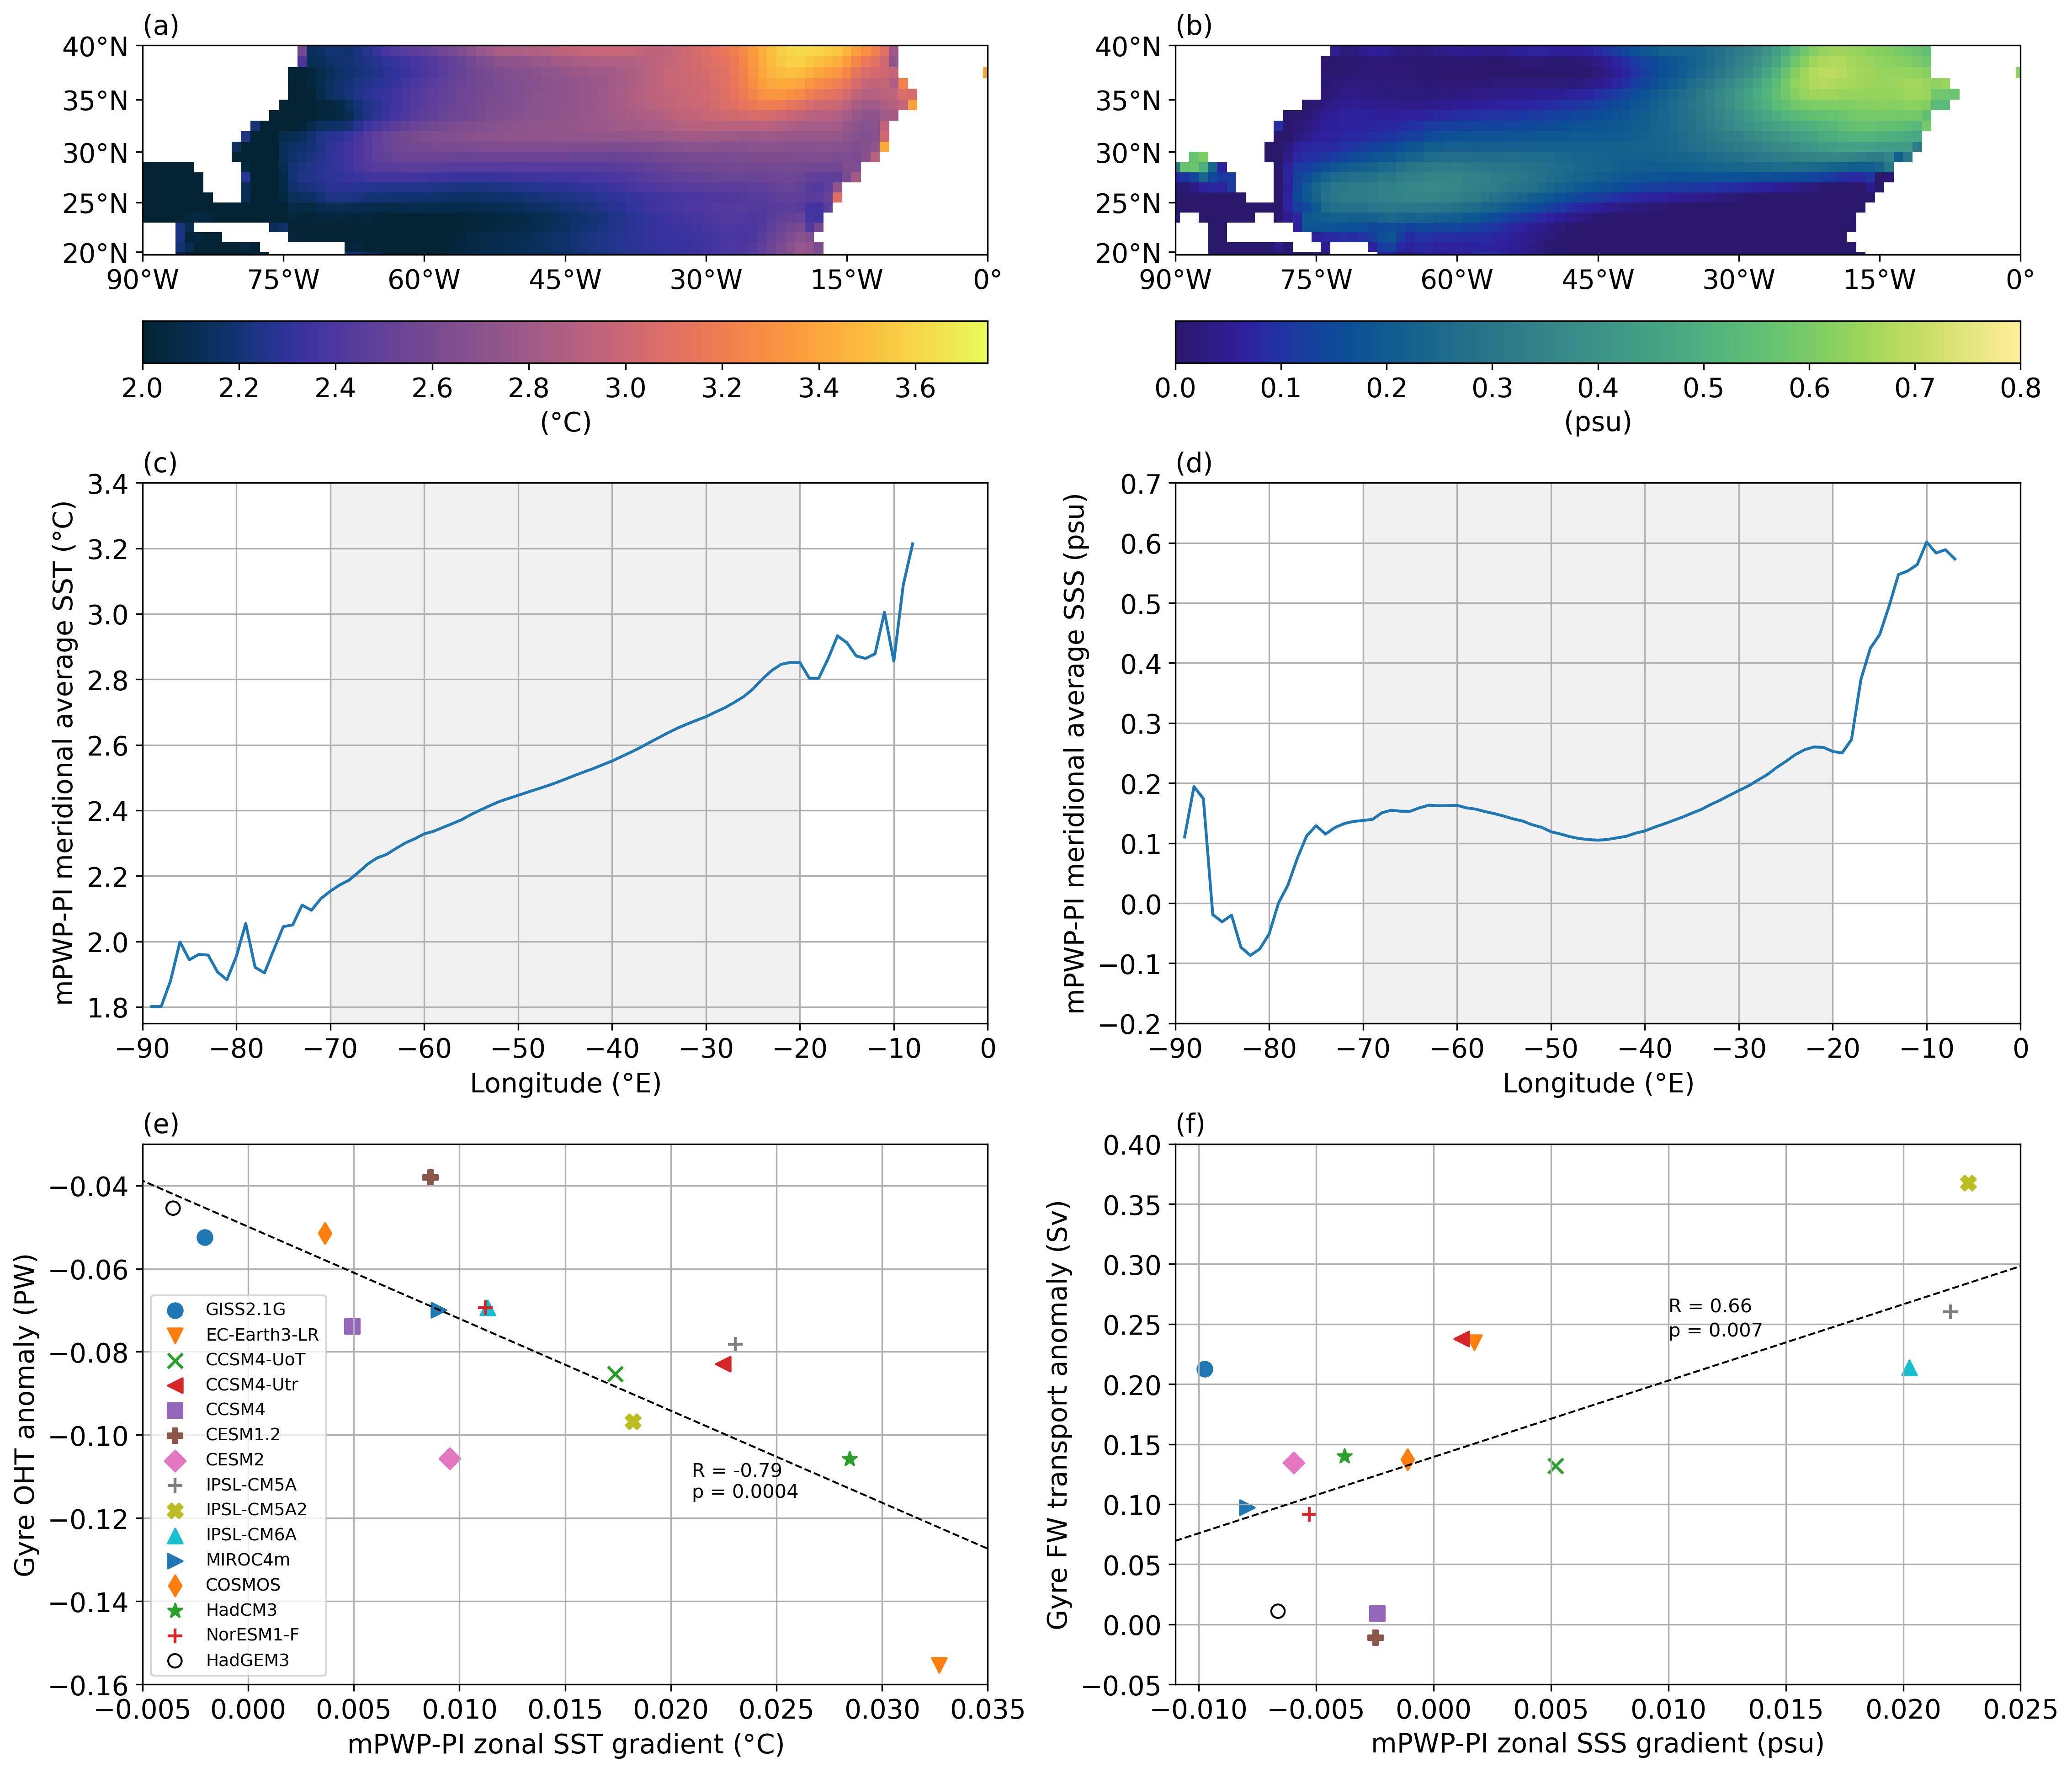

In [38]:
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
plt.rcParams['axes.labelsize'] = 14

fig1 = plt.subplots(figsize=(15,15), constrained_layout=True, dpi=300)

ax1 = plt.subplot(321, projection = ccrs.Miller()) 
im = ax1.pcolormesh(sstE280.lon, sstE280.lat, sstEoi400[:-1].mean(dim='model')-sstE280[:-1].mean(dim='model'), transform = ccrs.PlateCarree(), cmap='cmo.thermal', shading='auto', vmin = 2, vmax=3.75)
ax1.set_title('(a)', loc='left',fontsize=14)
ax1.set_xlim([-90,0])
ax1.set_ylim([20,40])
plt.colorbar(im, ax=ax1, location='bottom', label='($\degree$C)')

ax1.set_xticks(np.arange(-90,1,15), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)

ax1.set_yticks(np.arange(20,41,5), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax1.yaxis.set_major_formatter(lat_formatter)

ax2 = plt.subplot(323)
plt.plot(sstE280.lon, (sstEoi400[:-1].mean(dim='model')-sstE280[:-1].mean(dim='model')).where(sstE280.lon<0).where(sstE280.lon>-90).where(sstE280.lat>20).where(sstE280.lat<40).weighted(weights).mean(dim='lat'))
ax2.set_xlim([-90,0])
ax2.set_ylim([1.75,3.4])
ax2.axvspan(lon_bnds[1],lon_bnds[0], color='lightgrey',alpha=0.3)
ax2.grid()
ax2.set_xlabel('Longitude ($\degree$E)', fontsize=14)
ax2.set_ylabel('mPWP-PI meridional average SST ($\degree$C)', fontsize=14)
ax2.set_title('(c)', loc='left',fontsize=14)

ax1 = plt.subplot(322, projection = ccrs.Miller()) 
im = ax1.pcolormesh(sssE280.lon, sssE280.lat, sssEoi400[:-1].mean(dim='model')-sssE280[:-1].mean(dim='model'), transform = ccrs.PlateCarree(), cmap='cmo.haline', shading='auto', vmin = 0, vmax=0.8)
ax1.set_xlim([-90,0])
ax1.set_ylim([20,40])
ax1.set_title('(b)', loc='left',fontsize=14)
plt.colorbar(im, ax=ax1, location='bottom', label='(psu)')

ax1.set_xticks(np.arange(-90,1,15), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)

ax1.set_yticks(np.arange(20,41,5), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax1.yaxis.set_major_formatter(lat_formatter)

ax2 = plt.subplot(324)
plt.plot(sssE280.lon, (sssEoi400[:-1].mean(dim='model')-sssE280[:-1].mean(dim='model')).where(sssE280.lon<0).where(sssE280.lon>-90).where(sssE280.lat>20).where(sssE280.lat<40).weighted(weights).mean(dim='lat'))
ax2.axvspan(lon_bnds[1],lon_bnds[0], color='lightgrey',alpha=0.3)
ax2.set_xlim([-90,0])
ax2.set_ylim([-0.2,0.7])
ax2.grid()
ax2.set_xlabel('Longitude ($\degree$E)', fontsize=14)
ax2.set_ylabel('mPWP-PI meridional average SSS (psu)', fontsize=14)
ax2.set_title('(d)', loc='left',fontsize=14)

ax2 = plt.subplot(325)
markers = ["o","v","x","<","s","P","D","+","X","^",">","d","*","+","o"]
for j in range(0,len(modellist)-1):
    scatter = ax2.scatter(gradsst[j], difoht[j], s=60, c = 'C'+str(j), label=modellist[j], marker=markers[j])

scatter = ax2.scatter(gradsst[-1], difoht[-1], s=50, facecolors='none', edgecolors = 'k', label=modellist[-1], marker=markers[-1])

x = np.arange(-0.02,0.06,0.01)
ax2.plot(x, x*p1[0]+p1[1], color='black',linewidth =1, linestyle ='--')    
ax2.text(0.021,-0.11,'R = %.2f' %(p1[2]), fontsize=10)
ax2.text(0.021,-0.115,'p = %.4f' %(p1[3]), fontsize=10)
ax2.set_xlim([-0.005,0.035])
ax2.set_ylim([-0.16,-0.03])

ax2.grid()
ax2.set_xlabel('mPWP-PI zonal SST gradient ($\degree$C)', fontsize=14)
ax2.set_ylabel('Gyre OHT anomaly (PW)', fontsize=14)
ax2.legend(fontsize=9.)
ax2.set_title('(e)', loc='left',fontsize=14)

ax2 = plt.subplot(326)
markers = ["o","v","x","<","s","P","D","+","X","^",">","d","*","+","o"]
for j in range(0,len(modellist)-1):
    scatter = ax2.scatter(gradsss[j], diffw[j], s=60, c = 'C'+str(j), label=modellist[j], marker=markers[j])

scatter = ax2.scatter(gradsss[-1], diffw[-1], s=50, facecolors='none', edgecolors = 'k', label=modellist[-1], marker=markers[-1])
ax2.grid()
ax2.set_xlabel('mPWP-PI zonal SSS gradient (psu)', fontsize=14)
ax2.set_ylabel('Gyre FW transport anomaly (Sv)', fontsize=14)
ax2.set_title('(f)', loc='left',fontsize=14)

x = np.arange(-0.02,0.06,0.01)
ax2.plot(x, x*p2[0]+p2[1], color='black',linewidth =1, linestyle ='--')  
ax2.text(0.01, 0.26,'R = %.2f' %(p2[2]), fontsize=10)
ax2.text(0.01,0.24,'p = %.3f' %(p2[3]), fontsize=10)
ax2.set_xlim([-0.011,0.025])
ax2.set_ylim([-0.05,0.40])

plt.savefig('fig12.png', bbox_inches='tight')